# **Machine Learning Reconstruction of Surface Ocean pCO₂**
Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

**Group 2: Primanta Bangun, Samuel Kortchmar, Sarika de Bruyn, Juan Palacios**

<b>
<font size="12">
<span style='color:orange'>Introduction</span> 
</font>
</b>

The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

How good are these methods? Since the real full-coverage pCO2 of the ocean is unknown, we need another approach to assess the skill of ML-based reconstructions. Our answer is the **Large Ensemble Testbed (LET)**, which provides full-coverage pCO₂ output from Earth System Models, as well as associated driver varibles also from the ESM. In the context of this testbed, we can sample the pCO2 in the same pattern as real-world SOCAT and then reconstruct. Since the full-field pCO2 field is known ("Model Truth"), we can directly evaluate of ML reconstruction performance. With this approach, it has been shown that ML methods can capture seasonal variability well, they often overestimate decadal variability, particularly in regions with limited data coverage (Gloege et al. 2021). Bennington et al. (2022) incorporates a methodology to use a **pCO₂-Residual** approach to improve ML-based pCO₂ reconstructions.

This project builds upon previous work by decomposing **pCO₂-Residual** into **pCO₂-Residual-seasonal+trend** and **pCO₂-Residual-de-seasonal** (stochastic component) to improve ML-based pCO₂ reconstructions. The **pCO₂-Residual** method removes the temperature-driven component from pCO₂ before applying ML, thereby reducing the dominance of temperature in predictions and enhancing the ability of the model to capture non-temperature-driven variability. The **pCO₂-Residual-seasonal+trend** captures characteristics that are linear or almost deterministic in terms of seasonality. **pCO₂-Residual-de-seasonal** captures the remaining stochasticity of **pCO₂-Residual**.

Inspired by the paper from Stamell et al. (2020) we decided to take combine the two most promising models from this paper: XGBoost and Forward Neural Networks. Stamell et al. (2020) indicated how the seasonal component was better predicted by XGBoost, while decadal and sub-decadal components were better predicted by Neural Networks(see Figure 5 and Figure 4 below, taken from Stamell et al. (2020)). 

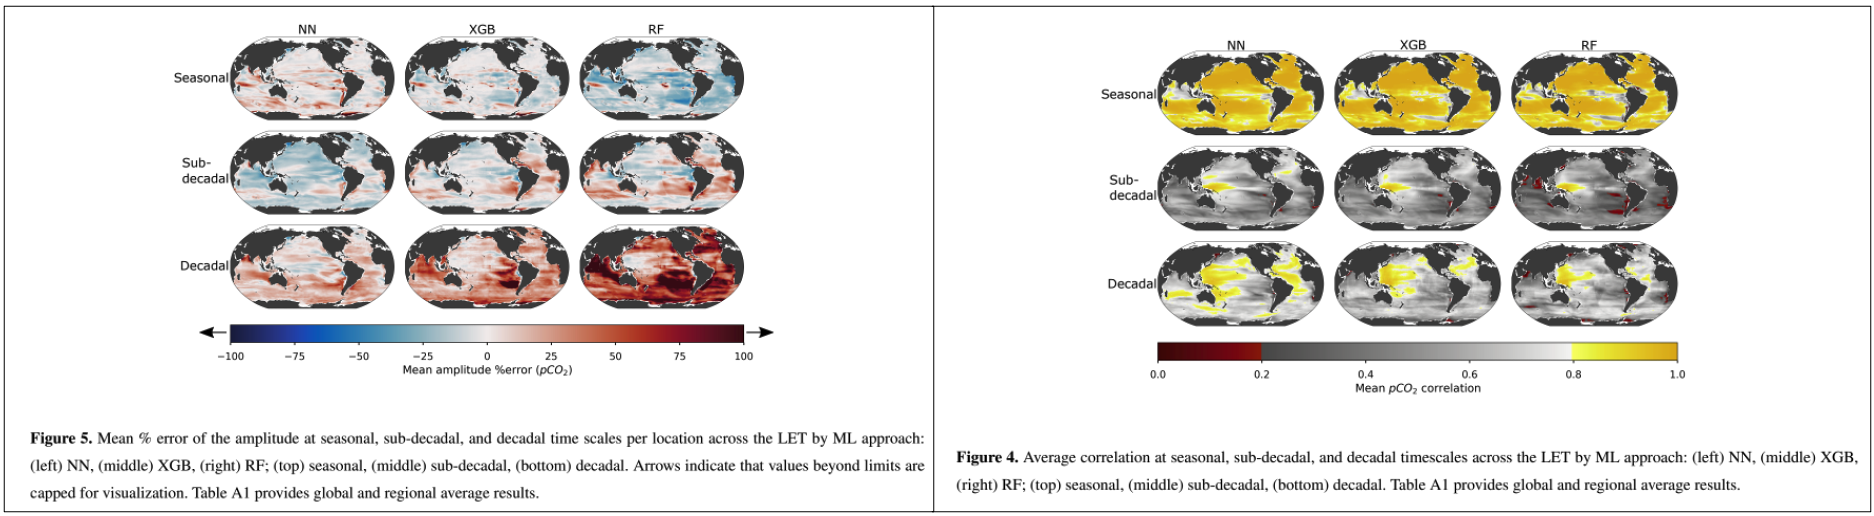

In [4]:
from IPython.display import Image
Image(filename="../images/Stamell.png", width=2000)

In this project we decided to divide **pCO₂-Residual** into **pCO₂-Residual-seasonal+trend** and **pCO₂-Residual-de-seasonal** (stochastic component) to improve ML-based pCO₂ reconstructions. For **pCO₂-Residual-seasonal+trend**, we use XGBoost to make a partial reconstruction of **pCO₂-Residual**. For **pCO₂-Residual-de-seasonal** we use a Neural Networks to make the remaining reconstruction. After completing the partial reconstructions, we add them together and analyze the results. Our study:

1. Implements an **XGBoost-based pCO₂-Residual-seasonal+trend reconstruction**
2. Implements a **Feed Forward Neural Network-based pCO₂-Residual-de-seasonal reconstruction**
3. Evaluates reconstruction performance using a Large Ensemble Testbed, with **bias and correlation metrics** as in Gloege et al (2021).

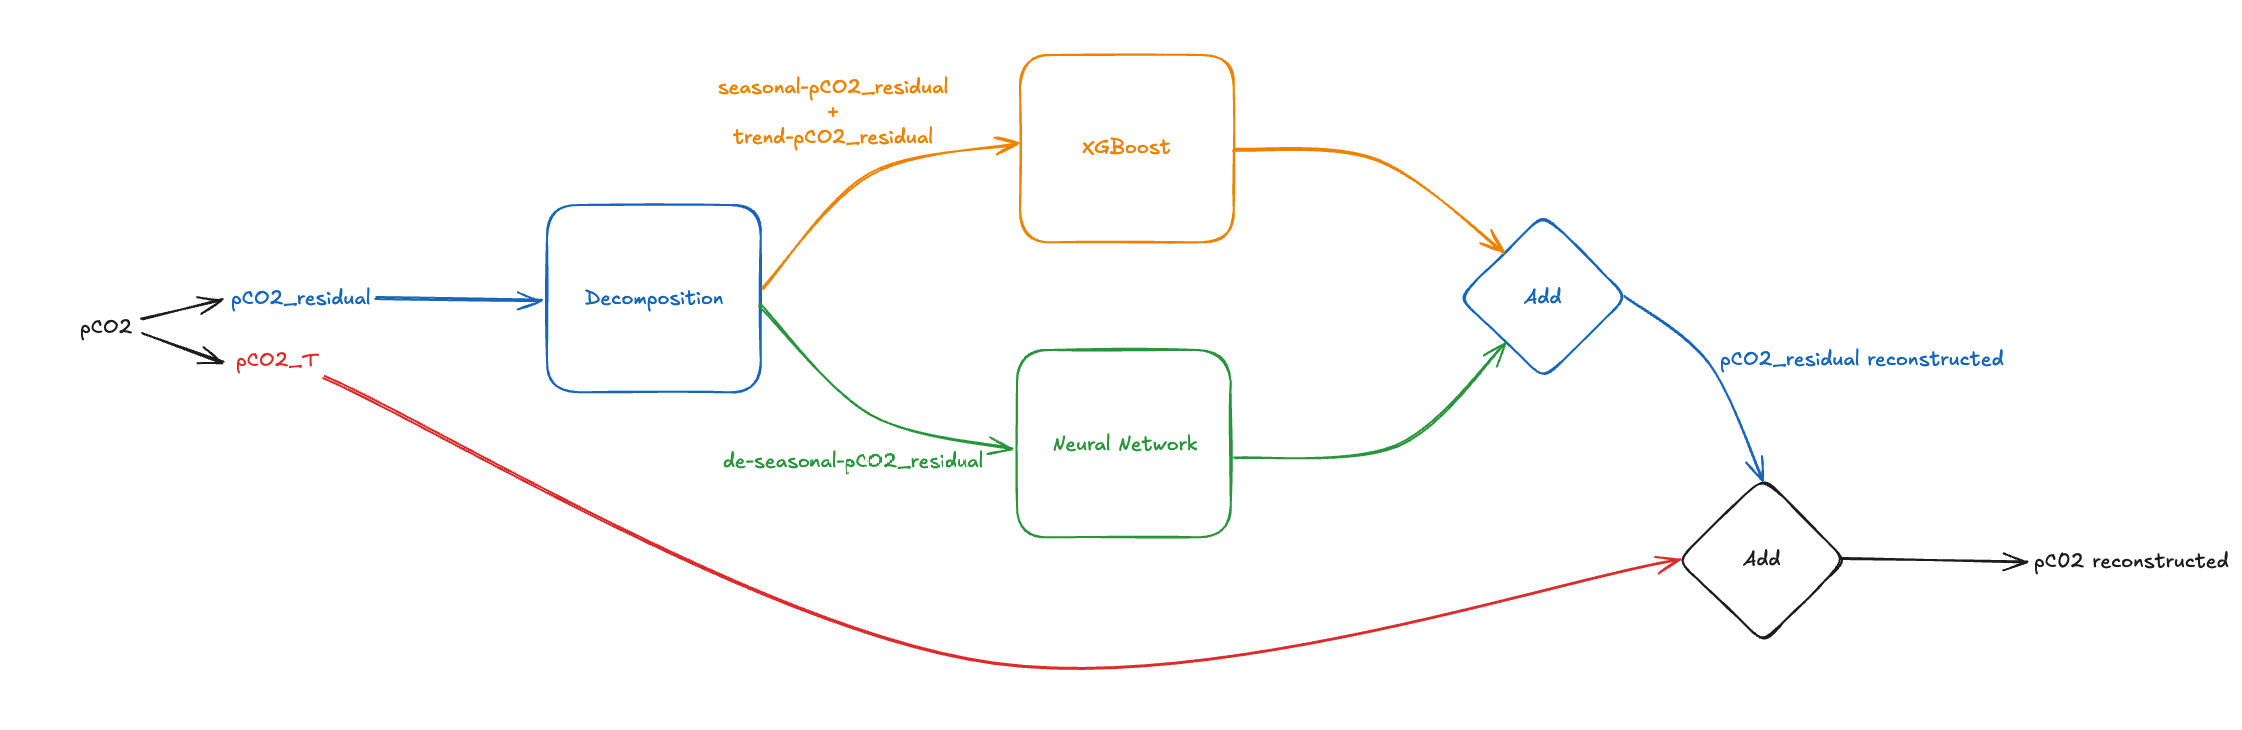

In [5]:
Image(filename="../images/diagram.png", width=2000)

<b>
<font size="12">
<span style='color:orange'> 0. Important for Reviewer </span> 
</font>
</b>

# Running Notes
1. Users need to enter their GitHub/LEAP-Pangeo username at the end of Section 2.
2. Several time-consuming steps have outputs saved to files, so they only need to be run initially or if changes are made:  
    - Section 2.3: ML Training (~1 minute/ESM member)  
    - Section 2.4: Reconstruction/Inference (~1 minute/ESM member)  
    - Section 2.4.1: Summation of pCO2-Residual and pCO2-T to recover pCO2 (~15 seconds/ESM member)


    With a **128GB GPU**, actual runtimes may vary based on system load and selected members, but this serves as a general guideline.

3. If users wish to run the complete model they need to run this notebook twice:
   
Step 1: Run the notebook by setting **__MODEL_TYPE__="xgb"** - this step will train the XGBoost model. Run starting here up to and including section 2.3

Step 2: Run the notebook by setting **__MODEL_TYPE__="nn"** - this step will train the Neural Network model. Run starting here until rest of notebook

4. Users should use the GPU to run **__MODEL_TYPE__="nn"**

<div class="alert alert-block alert-info">
<b>your_username:</b> The username of the person running the code. 
<p><b>owner_username:</b> The username of the notebook owner.</p>
</div>

<div class="alert alert-warning">
<b>runthiscell:</b>(Default = 1) Disable a cell by setting <b>runthiscell=0</b>. Reviewers should set <b>runthiscell=-1</b> to save time and space. 
</div>

In [7]:
your_username = 'sarika-debruyn'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'JuanPalaciosGodoy'  # Reviewer should not change this name

In [20]:
# define model
__MODEL_TYPE__ = "xgb" # "xgb" or "nn"
__READ_DATA_FROM_MEMORY__ = False
__ONLY_FIRST_MEMBER__ = False

<b>
<font size="12">
<span style='color:orange'> 1. Input (Features) Sources</span> 
</font>
</b>

The **input features** for the machine learning model are derived from **pre-processed Earth System Model (ESM) outputs or inputs**

### **Feature and Target Variables for the ML Model**
The features used for training the **pCO₂-Residual machine learning model** are listed below:


| **Feature** | **Description** | **ESM Input or Output?** | 
|------------|----------------|----------------|
| **SST (Sea Surface Temperature)** | Simulated ocean surface temperature | **ESM Output** |  
| **SST_anom** | SST anomaly from climatology | **ESM Output** |  
| **SSS (Sea Surface Salinity)** | Simulated surface ocean salinity | **ESM Output** |  
| **SSS_anom** | SSS anomaly from climatology | **ESM Output** |  
| **MLD_clim_log** | Log-transformed climatological mixed layer depth | **ESM Output** |  
| **Chl-a (Chlorophyll concentration)** | Proxy for biological activity (log-transformed) | **ESM Output** |  
| **Chl-a_anom** | Anomaly of Chl-a | **ESM Output** |  
| **xCO₂ (Atmospheric CO₂ concentration)** | Atmospheric CO₂ mole fraction | **ESM Input, from data** |  
| **A, B, C** | Space on the globe | **See Bennington et al. 2022, Table 1** |  
| **T0, T1** | Time | **See Bennington et al. 2022, Table 1** |  


The **target variable** for reconstruction is:
- **pCO₂-Residual**: This deviation from the temperature-driven component of pCO₂, reducing SST's dominance in ML reconstructions and improving model performance in data-sparse regions (detailed below).
- **pCO₂-Residual-seasonal+trend**: This is the trend + seasonal component of pCO₂-Residual
- **pCO₂-Residual-deseasonal**: This is the de-seasonal component of pCO₂-Residual

### **Key Considerations:**
- **pCO₂-Residual**: By removing the temperature-driven component from pCO₂, we enhance the ability of machine learning models to capture **non-temperature-driven variability**, particularly in poorly observed regions.
- **pCO₂-Residual** = pCO₂-Residual-trend + pCO₂-Residual-seasonal + pCO₂-Residual-deseasonal
- **Data Subsampling Based on SOCAT**: The use of a **SOCAT-derived mask** ensures that the ML model is trained and evaluated using a realistic observational distribution, mitigating potential biases from uneven data coverage.

### **Final Input Structure**:
- **Feature Matrix**: `(N, 12)`, where `N` represents the number of samples, and 12 predictor variables are used.
- **Target Variable**: `pCO₂-Residual`, which the model aims to reconstruct.


### **Target Variables Relationships**:

#### **Temperature-driven component** of pCO₂::

$$
\text{pCO}_{2,T} = \overline{\text{pCO}_2} \cdot \exp\left[ 0.0423 \cdot (T - \overline{T}) \right]
$$

- $ \overline{\text{pCO}_2} $: long-term mean of surface ocean pCO₂  
- $ T $: sea surface temperature at a given time/location  
- $ \overline{T} $: long-term mean sea surface temperature  
- $ 0.0423 $: empirically derived constant (from Takahashi et al., 1993)


#### **Residual** of pCO₂::

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_2 - \text{pCO}_{2,T}
$$

#### **Seasonal, Trend, and De-seasonal components** of pCO₂::

The residual is then decomposed into three separate components such that:

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_{2,seasonal} + \text{pCO}_{2,deseasonal} + \text{pCO}_{2,trend}
$$

The seasonal and deseasonal components are then used as the **target variables** in ML training, helping disentangle the direct solubility-driven temperature effect from other biogeochemical processes.

Later in the notebook, we recover the total pCO2 by **adding the temperature component back** to the residual:

$$
\text{pCO}_2 = \text{pCO}_{2,\text{Residual}} + \text{pCO}_{2,T}
$$



# 1.1 Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [21]:
%%capture
!pip install tensorflow
!pip install keras
!pip install pytorch-ignite

In [22]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
import torch
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial
from lib.paths_utils import SavingPaths
from lib.model_utils import train_member_models, Models


In [23]:
# the target variable we reconstruct:
target_sel = ['pco2_residual_deseasonal'] if __MODEL_TYPE__ == "nn" else ['pco2_residual_trend_plus_seasonal']

# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

In [24]:
### Setting the date range to unify the date type 

# Define date range
__GRID_SEARCH_APPROACH__ = 'nmse'
__DATE_RANGE_START__ = '2004-01-01T00:00:00.000000000'
__DATE_RANGE_END__ = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=__DATE_RANGE_START__, 
                      end=__DATE_RANGE_END__,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

In [25]:
# define loading and saving paths
saving_paths = SavingPaths(
    your_username=your_username,
    owner_username=owner_username,
    init_date=init_date,
    fin_date=fin_date,
    grid_search_approach=__GRID_SEARCH_APPROACH__,
    model=__MODEL_TYPE__
)

In [26]:
### set up for getting files from leap bucket 
fs = gcsfs.GCSFileSystem()


# 1.2  Earth System Models and their Ensemble Members

We collect the available ensemble members then randomly select up to 3 members for each ESM. 


In [27]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(saving_paths.inputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)


In [28]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']

selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


<b>
<font size="12">
<span style='color:orange'> 2. ML Reconstruction</span> 
</font>
</b>

The goal is to reconstruct the full field of pCO2 residuals using trained ML models, enabling evaluation across both observed (SOCAT-like) and unobserved (unseen) regions

# 2.1 Data Split

We split data to training data set and testing dataset based on date.

In [29]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i]) ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i]) ### 20% test days set ### 

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0,len(select_dates)):
    
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
    
test_year_mon = []

for i in range(0,len(test_dates)):
    
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

# 2.2 Hyperparameters

In [30]:
__SEED__ = 10
torch.manual_seed(__SEED__)

if Models(__MODEL_TYPE__) == Models.NEURAL_NETWORK:
    params = {
        'input_nodes':13,
        'hidden_nodes':250,
        'output_nodes':1,
        'epochs':3000,
        'lr': 1e-03
    }
elif Models(__MODEL_TYPE__) == Models.XGBOOST:
    params = {
        'n_estimators': 500,  # Number of boosting rounds
        'max_depth': 6,  # Maximum depth of each tree to control model complexity
        'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
        'subsample': 0.8,  # Fraction of samples used for training each tree
        'colsample_bytree': 0.8,  # Fraction of features used per tree
        'gamma': 0.1,  # Minimum loss reduction required for further partitioning
        'min_child_weight': 5,  # Minimum sum of instance weight in a leaf node
        'reg_alpha': 0.1,  # L1 regularization to reduce model complexity
        'reg_lambda': 1.0,  # L2 regularization for preventing overfitting
        'objective': 'reg:squarederror',  # Loss function for regression tasks
        'n_jobs': 30,  # Number of parallel threads to use for training
        'eval_metric': 'rmse',
        'early_stopping_rounds': 50  # Stop training if performance doesn't improve for 50 rounds
    }
else:
    raise ValueError(f"model {__MODEL_TYPE__} not supported! Please choose a model in [`{Models.NEURAL_NETWORK.value}`, `{Models.XGBOOST.value}`]")

### Important Note: Run ML (2.3) and Reconstruction (2.4) Part Only Once

The **ML Reconstruction** step needs to be run **only once** for each ML model developed. This helps save computational resources and execution time.

The reconstruction data is saved under our **own username-specific workspace** in GCS. This means that even if you exit and re-enter JupyterHub, your data will remain available, eliminating the need for reprocessing.

### Before Running Again:
Before re-running the ML training steps, make sure a new experiment is actually necessary. Avoiding redundant computations helps optimize time and resource usage. It's also a good idea to monitor your storage regularly and clean up unnecessary files. If you're certain that no new experiment is needed, you can comment out the relevant code (set runthiscell = "0") to prevent accidental re-execution.

For reviewer, set runthiscell to -1.

# 2.3 ML Training

To avoid re-run the ML training, set runthiscell = 0 

## ML train/val/test data
The ML model was trained on **masked synthetic data** that mimics real-world observational sampling patterns (SOCAT). Specifically, for each ensemble member, we:

1. **Filtered valid samples** by selecting grid cells that have:
   - No missing values in input features or the target (`pCO₂-Residual`),
   - Physically realistic `pCO₂-Residual` values (between -250 and 250 μatm),
   - An ocean mask indicating valid ocean regions.

2. **Identified SOCAT-like samples** using a binary `socat_mask`.  
   - We defined the **training pool** as grid cells where **`socat_mask == 1`**, and the time falls within a list of pre-selected training months (`year_mon`).
   - Similarly, **testing data** was drawn from SOCAT-like samples falling into the `test_year_mon` time range.

3. **Performed a secondary train/val split** (within the training pool) using a stratified random seed matrix (`random_seeds`), where the seed location is tied to each ensemble member to ensure reproducibility and model diversity across members.

4. The **“unseen” data**, i.e., where **`socat_mask == 0`** but data is otherwise valid, was reserved for reconstruction evaluation in non-observed regions.

This ensures that:
- Training and testing sets do **not overlap in time** (`year_mon` vs. `test_year_mon`),
- And are drawn from the same spatial sampling mask, preserving the real-world SOCAT sampling pattern.



In [ ]:
if not __READ_DATA_FROM_MEMORY__:  
    
    seed_loc_dict = defaultdict(dict)
    for ens,mem_list in mems_dict.items():
        sub_dictt = dict()
        for no,mem in enumerate(mem_list):
            sub_dictt.update({mem:no})
        seed_loc_dict.update({ens:sub_dictt})

    if __ONLY_FIRST_MEMBER__:
        print("Reviewing process: Running ML only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict
    
    train_member_models(
        saving_paths=saving_paths,
        features=features_sel,
        target=target_sel,
        train_year_mon=year_mon,
        test_year_mon=test_year_mon,
        run_selected_mems_dict=run_selected_mems_dict,
        seed_loc_dict=seed_loc_dict,
        dates=dates,
        model_type=__MODEL_TYPE__,
        is_training=True,
        **params
    )
            

2025-04-29 18:11:57.655576
ACCESS-ESM1-5 member_r10i1p1f1
Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.json
Local model saving process complete.
test performance metrics: {'mse': 42.438170596002145, 'mae': 4.384799247535554, 'medae': np.float64(3.013752960771411), 'max_error': np.float64(97.43568815344298), 'bias': np.float64(-0.17627704089943386), 'r2': 0.9154561067344921, 'corr': np.float64(0.9576685617898728), 'cent_rmse': np.float64(6.512073132565073), 'stdev': np.float32(20.556904), 'amp_ratio': np.float64(0.8132994779850793), 'stdev_ref': np.float64(22.404600558721125), 'range_ref': np.float64(320.75740023610456), 'iqr_ref': np.float64(25.555605155883118)}
ACCESS-ESM1-5 member_r5i1p1f1
Starting local model saving process...
Model successfully saved locally at: output/model_saved/model_pCO2_2D_ACCESS-ESM1-5_r5i1p1f1_mon_1x1_200401_202312.json
Local model saving process com

# **Reminder for reviewer**: 

Set __MODEL_TYPE_ to the other model. For instance, if you trained with "nn", now train again with "xgb"

# 2.4 Reconstruction

### What Are We Reconstructing?

After training the model, we generate pCO₂ predictions not just for evaluation but also for reconstructing spatial fields across different sample categories:

1. **`unseen_sel`**: These are grid points that are valid (no missing values, within physical bounds) but **not observed** in the SOCAT dataset (i.e., `socat_mask == 0`). Predictions on these samples (`y_pred_unseen`) test the model’s ability to generalize beyond observed regions.

2. **`sel`**: These are SOCAT-like samples where `socat_mask == 1`. They include both training and test data (depending on the year/month). Predictions here (`y_pred_seen`) are used to assess performance where observations exist.


### Explanation of Reconstruction Output Variables

Each column added to the DataFrame (`df`) serves a specific purpose in evaluation and reconstruction:

| Variable | Description |
|----------|-------------|
| `pCO2_truth` | The actual pCO₂ residual values|
| `pCO2_recon_full` | The full reconstruction result (predicted values across both SOCAT and unseen regions). |
| `pCO2_recon_unseen` | Predicted values only for unseen regions (where `socat_mask == 0`). |


If you have not changed your ML, the reconstruction step (~1 minute/member) does not need to be re-run

In [ ]:
if not __READ_DATA_FROM_MEMORY__:

    if __ONLY_FIRST_MEMBER__:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict

    train_member_models(
        saving_paths=saving_paths,
        features=features_sel,
        target=target_sel,
        train_year_mon=year_mon,
        test_year_mon=test_year_mon,
        run_selected_mems_dict=run_selected_mems_dict,
        seed_loc_dict=seed_loc_dict,
        dates=dates,
        model_type=__MODEL_TYPE__,
        is_training=False,
        **params
    )

# 2.5 How do the different models evaluate features?

We wanted to understand the different impacts of the features on the predictions across the two models.

Some interesting trends are that:
1. We see higher residuals when `mld_clim_log` is lower.
2. We see higher residuals when `chi_log` is lower.
3. In the NN, we see higher residuals on the lower and higher ends of `A`.

This might indicate that generally the pCO2 is harder to predict when the mixed layer is smaller, which makes sense, as there is less homogeneity in the surface.


In [ ]:
from lib.model_utils import get_first_member_predictions
from lib.feature_visualization import plot_residuals_side_by_side
from collections import defaultdict

seed_loc_dict = defaultdict(dict)
for ens,mem_list in selected_mems_dict.items():
    sub_dictt = dict()
    for no,mem in enumerate(mem_list):
        sub_dictt.update({mem:no})
    seed_loc_dict.update({ens:sub_dictt})

first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member

xgb_output, nn_output, data = get_first_member_predictions(
    saving_paths=saving_paths,
    features=features_sel,
    target=target_sel,
    train_year_mon=year_mon,
    test_year_mon=test_year_mon,
    run_selected_mems_dict=run_selected_mems_dict,
    seed_loc_dict=seed_loc_dict,
    dates=dates,
    **params
)
data_xgb_aligned, data_nn_aligned = align_training_data(data_xgb, data_nn)

plot_residuals_side_by_side(xgb_output, nn_output, data, features_sel)


# 2.6 Recovering Full Surface Ocean pCO₂ from Residual Components

After reconstructing the pCO₂-Residual separately into its seasonal + trend component (via XGBoost) and deseasonal stochastic component (via Neural Network), we sum these two reconstructions. Then, we add back the temperature-driven component (pCO₂-T) that was originally removed during preprocessing. This yields a physically complete estimate of the surface ocean pCO₂, suitable for evaluating air-sea CO₂ fluxes and analyzing variability across timescales.

In [ ]:
if not __READ_DATA_FROM_MEMORY__: 
    if __ONLY_FIRST_MEMBER__:
        supporting_functions.calc_recon_pco2_modified(saving_paths.ensemble_dir, saving_paths.recon_output_dir, saving_paths.recon_output_dir_alternate, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2_modified(saving_paths.ensemble_dir, saving_paths.recon_output_dir, saving_paths.recon_output_dir_alternate, selected_mems_dict, init_date, fin_date)



**Reviewers should not run the following cell**.


In [ ]:
from google.cloud import storage

if not __ONLY_FIRST_MEMBER__:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)


#  2.7 Visualize the reconstruction for 1 month

In [ ]:
# Plot settings
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load original member data from ESM output
member_dir = f"{saving_paths.ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://' + member_path, engine='zarr').sel(time=slice(str(dates[0]), str(dates[-1])))
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load reconstructed pCO₂ data
recon_dir = f"{saving_paths.recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
full = xr.open_zarr(recon_path)["pCO2_recon_full"]

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
recon_data = full.sel(time=chosen_time)[0, ...]

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
socat_mask_data = xr.open_zarr(saving_paths.socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Start plotting side-by-side
with plt.style.context(plot_style):
#    fig = plt.figure(figsize=(10, 4), dpi=200)
    fig = plt.figure(figsize=(8, 3), dpi=200)
    worldmap = SpatialMap2(
        fig=fig, region='world',
        cbar_mode='single',  # Use one shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]
    )

    # Plot original (masked) and reconstructed data
    sub0 = worldmap.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap.add_plot(
        lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data,
        vrange=vrange, cmap=cmap, ax=1
    )

    worldmap.set_title("Original pCO₂ (2021-01)", ax=0, fontsize=13)
    worldmap.set_title("Reconstructed pCO₂ (2021-01)", ax=1, fontsize=13)

    colorbar = worldmap.add_colorbar(sub0, ax=0)
    worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=12)

    plt.show()


The figure compares the original sparse pCO₂ selected from the first ESM member, consistent with real-world sampling, and the corresponding machine-learning-based reconstruction for January 2021.

<b>
<font size="12">
<span style='color:orange'> 3. Evaluation </span> 
</font>
</b>

This section addresses the key research question:

“Can we reliably reconstruct global ocean surface pCO₂ fields from sparse data using ML?”

By comparing ML reconstructions to full-field ESM truth, we quantify how well the reconstruction captures spatial and temporal variability, particularly in regions with limited observational data.

# 3.1 Create a combined dataset with reconstruction and original 

We concatenate the outputs and ground truth from all members and ESMs into a single dataset, and then use this combined dataset to calculate bias, RMSE, and correlation.

In [ ]:
datasets = []
for ensemble, members in selected_mems_dict.items():
    mems_dict = {ensemble: members}  
    ds = concat_datasets(mems_dict, recon_output_dir = saving_paths.recon_output_dir, init_date = init_date, fin_date=fin_date)
    datasets.append(ds)
concated_dataset = xr.concat(datasets, dim="ens")
evaluator = XarrayEvaluator(concated_dataset)

ds_eval = evaluator.compute_all_metrics()
print(ds_eval)

# 3.2 Descriptive Statistics

We can use ds_eval to easily compute descriptive statistics. In this example, we take the average across all time steps and ESMs:

In this example, we select the Northern Hemisphere (ylat from 0 to 90), flatten the spatial dimensions, drop missing values, and generate a summary using describe(). This gives us a statistical overview (mean, std, min, max, etc.) of the bias in the Northern Hemisphere.

You can change the selection for other regions and timeframes and ensemble members.

In [ ]:
ds_eval_mean = (ds_eval['bias']*1).mean('ens').mean('time')
ds_eval_mean.sel(ylat=slice(0,90)).stack(z=['ylat','xlon']).dropna('z').to_dataframe().describe()['bias']

# 3.3 Bias Visualizations
Based on this, we could visualize bias between reconstruction and model truth, averaged over the 100 ensemble members, each with a 
monthly resolution over the period init_date through fin_date. Red and blue shading indicates regions where the reconstruction is biased high or low, respectively. 

## 3.3.1 How well does the reconstruction capture the mean pCO2 field? 

In [ ]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[1,1])
    vrange = [-10, 10, 5] 
    cmap = cm.cm.balance
    
    data = (ds_eval['bias'] * 1).mean('ens').mean('member').mean('time')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    
    data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange[0:2], cmap=cm.cm.balance, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()


This visualization shows where the ML reconstruction diverges from the original ESM pCO2. This helps pinpoint geographical regions where the ML model struggles which is crucial for understanding weaknesses in data-sparse zones like the Southern Ocean.

### 3.3.2 Does ESM impact the estimate of the bias? 

In [ ]:
plot_style = "seaborn-v0_8-talk"
ensemble_means = ds_eval['bias'].mean(dim=['member', 'time'])

ensemble_names = list(ds_eval['ens'].values) 

vrange = [-10,10, 5]
cmap = cm.cm.balance

num_ensemble = len(ensemble_names)  
num_cols = 3  
num_rows = (num_ensemble + num_cols - 1) // num_cols 
with plt.style.context(plot_style):
    fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',  
                           colorbar=True,  
                           cbar_location='bottom',
                           nrows_ncols=[num_rows, num_cols]) 
    for i in range(num_ensemble):
        data = ensemble_means.isel(ens=i)
        data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)  
        data = xr_add_cyclic_point(data, cyclic_coord='xlon') 
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                                vrange=vrange[0:2], cmap=cmap, ax=i, linewidth_coast=0.5)
        worldmap.set_title(title=ensemble_names[i], ax=i, fontsize=14)

    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'Mean bias [uatm]', fontsize=14)

    worldmap.set_ticks(col, tmin=vrange[0], tmax=vrange[1], dt=vrange[2])

    col.ax.tick_params(labelsize=12)

    plt.show()


**Access-ESM1-5:**
- Generally low-to-moderate bias across most regions
- Noticeable underestimation (blue) in the equatorial Pacific and coastal zones
- Some overestimation (light red) in the North Pacific and Southern 

**CanESM5**
- Biases appear more diffuse
- model underestimates pCO₂ more strongly in the Indo-Pacific warm pool
- Some clear positive bias in the North Pacific and eastern Pacific

**MPI-ESM1-2-LR:**
- Shows the strongest regional biases, particularly in the tropical and South Pacific
- High bias clusters (red) suggest consistent overestimation in certain regions, possibly due to mismatches in seasonal cycles or regional drivers

#  3.4 Reconstructed variability on seasonal, sub-decadal, and decadal timescales, compared to original model

Before computing spatial correlation metrics, we decompose both the reconstructed and reference pCO₂ fields into their long-term trend, seasonal cycle, and residual components using STL-like decomposition. We then evaluate their agreement by calculating gridwise correlation and standard deviation for each component across all ensemble members and ESMs.


In [ ]:
# The calculation of these statistics takes about 1 min/member
ds_eval_corr = eval_spatial(selected_mems_dict, saving_paths.recon_output_dir, init_date, fin_date)

Phasing of reconstruction variability on seasonal, sub-decadal, and decadal, compared to original model. Correlation between 
reconstruction and original model on (a) seasonal, (b) sub-decadal, and (c) decadal time scales. 

Here, the average correlations across all ensemble members are shown. 

In [ ]:
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    # Setup Figure
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world',
                   cbar_mode='edge',
                   axes_pad=0.15,
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[3,1])
    
    # Colorbar ranges
    vrange_col1 = [0, 1, 0.2]
    cmap_col1 = cm.cm.oxy
    
    ##-----------------------------------------------------
    ## Ensemble mean
    ##-----------------------------------------------------
    # Correlation - Annual-variation
    data = ds_eval_corr['corr_seasonal'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)

    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub0 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=0)
    
    
    # Correlation - sub-decadal
    data = ds_eval_corr['corr_residual'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub2 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=1)
    
    # Correlation - decadal
    data = ds_eval_corr['corr_dec'].mean('ens').mean('member')
    data = data.roll(xlon=len(data.xlon) // 2, roll_coords=True)
    data = xr_add_cyclic_point(data, cyclic_coord='xlon')
    sub4 = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                            vrange=vrange_col1[0:2], cmap=cmap_col1, ax=2)
    
    # add colorbar
    col1 = worldmap.add_colorbar(sub0, ax=0, extend='min')
    worldmap.set_cbar_xlabel(col1, f'Mean correlation')
    worldmap.set_ticks(col1, vrange_col1[0], vrange_col1[1], vrange_col1[2])

    worldmap.grid[0].text(-0.2, 0.5, "Seasonal", transform=worldmap.grid[0].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[1].text(-0.2, 0.5, "Sub-seasonal", transform=worldmap.grid[1].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)
    
    worldmap.grid[2].text(-0.2, 0.5, "Decadal", transform=worldmap.grid[2].transAxes,
                           fontsize=14, fontweight='bold', va='center', ha='right', rotation=90)

    
    plt.show()

**1. Top Panel: Seasonal (∼1 year cycles)**
- Bright yellow across nearly all ocean basins shows high correlation (~1.0).
- This indicates the ML model very successfully captures the seasonal cycle of pCO₂ variability.
- Key insight: ML excels at modeling seasonal patterns — expected, since seasonality is regular and strongly driven by temperature and biological cycles, which are well-represented in the input features.

**2. Middle Panel: Sub-seasonal (∼2–6 months)**
- Patchy, dark red areas (low correlation) appear in the Indo-Pacific, South Atlantic, and Western Pacific.
- Grey areas show moderate correlation or data sparsity.
- Indicates that the ML model struggles more with short-term variability, which can be noisy and non-linear.
- Key insight: ML struggles with capturing high-frequency fluctuations, possibly due to:
    - Lack of input features with fast temporal response
    - Sparse data in SOCAT mask used for training

**3. Bottom Panel: Decadal (∼10+ years)**
- Mixed performance:
    - Strong correlation in equatorial and Indo-Pacific regions
    - Weaker (red) correlation in Southern Ocean and high latitudes
- Decadal signals are harder to capture due to:
    - Sparse temporal coverage
    - Limited interannual signal strength in some features (e.g., xCO₂ alone may not explain shifts)
- Key insight: ML captures decadal variability reasonably well in some regions, but likely overfits or underperforms where long-term dynamics are complex or under-sampled.

<b>
<font size="12">
<span style='color:orange'> 4. Model Performance by Ensemble Member </span> 
</font>
</b>

This section visualizes how well the model performs across different Earth System Models

In [ ]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# 4.1 Calculate performance metrics by ensemble
Function to calculate average metrics for each ensemble

In [ ]:
# Update the function to ensure index elements are strings
def calculate_ensemble_metrics(ds_eval):
    """Calculate average metrics for each ensemble"""
    # Get unique ensemble names and convert to strings
    ensembles = [str(ens) for ens in ds_eval['ens'].values]
    
    # Initialize DataFrame to store metrics
    metrics = ['bias', 'rmse', 'correlation']
    ensemble_metrics = pd.DataFrame(index=ensembles, columns=metrics)
    
    # Calculate average metrics for each ensemble
    for i, ens in enumerate(ds_eval['ens'].values):
        ens_str = ensembles[i]  # Use string version for index
        
        # For each metric, get the dimensions that actually exist
        for metric_name in ['bias', 'rmse', 'correlation']:
            if metric_name in ds_eval:
                # Select the data for this ensemble
                metric_data = ds_eval[metric_name].sel(ens=ens)
                
                # Get the actual dimensions of this data
                available_dims = list(metric_data.dims)
                
                # For bias, use absolute values to avoid positive/negative cancellation
                if metric_name == 'bias':
                    metric_data = np.abs(metric_data)
                
                # Calculate mean over all available dimensions
                ensemble_metrics.loc[ens_str, metric_name] = float(metric_data.mean(
                    dim=available_dims).values)
            else:
                # If the metric doesn't exist, set to NaN
                ensemble_metrics.loc[ens_str, metric_name] = np.nan
    
    return ensemble_metrics

In [ ]:
# Calculate metrics for each ensemble
ensemble_metrics = calculate_ensemble_metrics(ds_eval)

# Display summary table
print("Ensemble Performance Metrics Summary:")
print(ensemble_metrics.round(4))

In [ ]:
ensemble_metrics

# 4.2 Visualize Metrics with bar plots

In [ ]:
# Create figure with three subplots (one for each metric)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# 1. Plot Bias - Convert values to simple Python floats to avoid numpy issues
x_values = ensemble_metrics.index.tolist()
y_values = [float(v) for v in ensemble_metrics['bias']]
sns.barplot(x=x_values, y=y_values, ax=axes[0], color='#FF9999')  # Light red color
axes[0].set_title('Average Absolute Bias by Earth System Model', fontsize=14)
axes[0].set_xlabel('Earth System Model', fontsize=12)
axes[0].set_ylabel('Absolute Bias (µatm)', fontsize=12)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
# Add value labels on top of the bias bars
for i, v in enumerate(y_values):
    axes[0].text(i, v * 1.05, f'{v:.3f}', ha='center', fontsize=10)

# 2. Plot RMSE
y_values_rmse = [float(v) for v in ensemble_metrics['rmse']]
sns.barplot(x=x_values, y=y_values_rmse, ax=axes[1], color='#FFCC99')  # Light orange color
axes[1].set_title('Average RMSE by Earth System Model', fontsize=14)
axes[1].set_xlabel('Earth System Model', fontsize=12)
axes[1].set_ylabel('RMSE (µatm)', fontsize=12)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
# Add value labels on top of the RMSE bars
for i, v in enumerate(y_values_rmse):
    axes[1].text(i, v * 1.05, f'{v:.3f}', ha='center', fontsize=10)

# 3. Plot Correlation
y_values_corr = [float(v) for v in ensemble_metrics['correlation']]
sns.barplot(x=x_values, y=y_values_corr, ax=axes[2], color='#9999FF')  # Light blue color
axes[2].set_title('Average Correlation by Earth System Model', fontsize=14)
axes[2].set_xlabel('Earth System Model', fontsize=12)
axes[2].set_ylabel('Correlation Coefficient', fontsize=12)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
# Add value labels on top of the correlation bars
for i, v in enumerate(y_values_corr):
    axes[2].text(i, v * 1.05, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()  # This line ensures the figure is displayed

- The ML models generalize well across Earth System Models — no catastrophic failures (no low correlation, no huge biases).
- ACCESS-ESM1-5 and CanESM5 are easier to predict — possibly because their pCO₂ patterns are more "standard" (well-behaved seasonal cycles, smoother dynamics).
- MPI-ESM1-2-LR is more challenging:
    - More bias
    - Larger RMSE
    - Slightly lower correlation
- This may suggest that MPI's surface ocean CO₂ behavior is less predictable (maybe more complex biological or physical processes?).

# 4.3 Calculate and visualize performance by ocean regions

In [ ]:
# Define important ocean regions
regions = {
    'Global': {'lat_min': -90, 'lat_max': 90, 'lon_min': 0, 'lon_max': 360},
    'Equatorial Pacific': {'lat_min': -5, 'lat_max': 5, 'lon_min': 180, 'lon_max': 260},
    'North Atlantic': {'lat_min': 40, 'lat_max': 65, 'lon_min': 310, 'lon_max': 350},
    'Southern Ocean': {'lat_min': -75, 'lat_max': -40, 'lon_min': 0, 'lon_max': 360}
}

In [ ]:
# Initialize multi-index DataFrame for regional metrics
index = pd.MultiIndex.from_product([regions.keys(), ds_eval['ens'].values], names=['region', 'ensemble'])
metrics = ['bias', 'rmse', 'correlation']
regional_metrics = pd.DataFrame(index=index, columns=metrics)

In [ ]:
# Define important ocean regions (with adjusted boundaries)
regions = {
    'Global': {'lat_min': -90, 'lat_max': 90, 'lon_min': 0, 'lon_max': 360},
    'Equatorial Pacific': {'lat_min': -5, 'lat_max': 5, 'lon_min': 140, 'lon_max': 280},  # typical ENSO region
    #'North Atlantic': {'lat_min': 20, 'lat_max': 70, 'lon_min': 280, 'lon_max': 360},  # shifted a bit west
    'Southern Ocean': {'lat_min': -75, 'lat_max': -40, 'lon_min': 0, 'lon_max': 360}
}


# Initialize multi-index DataFrame for regional metrics
index = pd.MultiIndex.from_product([regions.keys(), ds_eval['ens'].values], names=['region', 'ensemble'])
metrics = ['bias', 'rmse', 'correlation']
regional_metrics = pd.DataFrame(index=index, columns=metrics)

# Calculate metrics for each region and ensemble
for region_name, bounds in regions.items():
    print(f"\nProcessing region: {region_name}")
    
    # Select data within region bounds
    region_data = ds_eval.sel(
        ylat=slice(bounds['lat_min'], bounds['lat_max']),
        xlon=slice(bounds['lon_min'], bounds['lon_max'])
    )
    
    # Debug: Print shape to verify data exists
    print(f"Region shape: {region_data['bias'].shape}")
    
    for ens in ds_eval['ens'].values:
        # For each metric
        for metric_name in ['bias', 'rmse', 'correlation']:
            try:
                # Select the data for this ensemble
                metric_data = region_data[metric_name].sel(ens=ens)
                
                # Check if we have non-NaN data
                if np.isnan(metric_data).all():
                    print(f"Warning: All NaN values for {region_name}, {ens}, {metric_name}")
                    regional_metrics.loc[(region_name, ens), metric_name] = np.nan
                    continue
                
                # Get the actual dimensions of this data
                available_dims = list(metric_data.dims)
                
                # For bias, use absolute values
                if metric_name == 'bias':
                    metric_data = np.abs(metric_data)
                
                # Calculate mean over all available dimensions
                regional_metrics.loc[(region_name, ens), metric_name] = float(metric_data.mean(
                    dim=available_dims).values)
            except Exception as e:
                print(f"Error calculating {metric_name} for {region_name}, {ens}: {e}")
                regional_metrics.loc[(region_name, ens), metric_name] = np.nan

# Display regional metrics summary
print("\nRegional Performance Metrics Summary:")
print(regional_metrics.round(6))

# 4.4 Create comparative plots for all three metrics across selected regions

In [ ]:
# Create comparative plots for all three metrics across selected regions
metrics_to_plot = ['bias', 'rmse', 'correlation']
metric_titles = ['Absolute Bias', 'RMSE', 'Correlation Coefficient']
metric_units = ['(µatm)', '(µatm)', '']
custom_palettes = [
    ['#8DD3C7', '#FFFFB3', '#BEBADA'],  # For Bias
    ['#FB8072', '#FDB462', '#B3DE69'],  # For RMSE
    ['#4C72B0', '#55A868', '#C44E52']   # For Correlation
]

# Set up a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Regions to show
regions_to_show = ['Global', 'Equatorial Pacific', 'Southern Ocean']

# Reshape data for plotting
plot_data = regional_metrics.reset_index()
plot_data = plot_data[plot_data['region'].isin(regions_to_show)]

# Plot each metric
for i, (metric, title, unit, palette) in enumerate(zip(metrics_to_plot, metric_titles, metric_units, custom_palettes)):
    # Create grouped bar plot
    sns.barplot(x='ensemble', y=metric, hue='region', data=plot_data, ax=axes[i], palette=palette)
    
    axes[i].set_title(f'{title} by Region and Earth System Model', fontsize=14)
    axes[i].set_xlabel('Earth System Model', fontsize=12)
    axes[i].set_ylabel(f'{title} {unit}', fontsize=12)
    axes[i].legend(title='Ocean Region', fontsize=10, title_fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add value labels to the bars
    for j, bar in enumerate(axes[i].patches):
        height = bar.get_height()
        if not np.isnan(height):  # Only add text if the value is not NaN
            axes[i].text(
                bar.get_x() + bar.get_width()/2,
                height + (axes[i].get_ylim()[1] - axes[i].get_ylim()[0])*0.02,  # Position relative to axis range
                f'{height:.3f}',
                ha='center',
                va='bottom',
                fontsize=8,
                weight='bold',
                rotation=90 if len(regions_to_show) > 2 else 0  # Rotate text if many regions
            )
    
    # Adjust y-axis to create space for the labels
    current_ylim = axes[i].get_ylim()
    axes[i].set_ylim([current_ylim[0], current_ylim[1] * 1.1])  # Add 10% more space

fig.suptitle('Model Performance Comparison Across Ocean Regions', fontsize=18, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust for the suptitle
plt.show()

- Equatorial Pacific is the hardest region to predict:
    - Large bias
    - Larger RMSE
    - Slightly lower correlation

- Southern Ocean is easier for the ML model:
    - Lowest bias and RMSE
    - Highest correlation

- MPI-ESM1-2-LR consistently struggles more in all regions, particularly in the Equatorial Pacific.

    - This could be because MPI simulates more complex El Niño/La Niña patterns, biological variability, or mixed-layer dynamics that your ML model finds harder to capture.

<b>
<font size="12">
<span style='color:orange'> 5. Conclusion</span> 
</font>
</b>

# 5.1 Findings

# 5.2 Contributions

**Primanta Bangun:** 

**Sarika de Bruyn:** Experimented with incorporating ENSO as a feature to improve baseline model, tried fixing toggling between XGBoost and Neural Network, edited and cleaned notebook for datastory

**Juan Palacios:** Implemented seasonal decomposition, and created separate models (XGBoost and Neural Network) to predict seasonal+trend and deseasonal pCO2 residuals independently, and aggregate both predictions into a final pCO2 residual prediction.

**Samuel Kortchmar:** Experimented with different visualizations of xgboost decision trees in an attempt to understand the evolution of feature importance during boosting rounds. However, it was difficult to derive any useful patterns from these visualizations and the effort was abandoned. Afterwards, he helped optimize the NNs for GPUs

# 5.3 Additional Information and Further Reading

### **Final Check for Redundant Files**  

#### **For Both Owners and Reviewers:**  
After execution is complete, review the project directory for any redundant files. Ensure that only necessary and relevant files are retained.  

#### **For Reviewers:**  
Once you have finished reviewing a project, you may delete files related to that project to free up storage space. However, be careful not to remove any data you still need.

As an **owner**, your reconstruction data is stored under:  

```
gs://leap-persistent/{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

If you are **reviewing someone else’s project**, their data and experiment results will be stored under your username in the following path:  

```
gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/
```

After completing the review, you can delete the files under `{owner_username}` in your directory to free up storage space. This ensures that only necessary data is retained while removing redundant files from past reviews.

In [26]:
if __ONLY_FIRST_MEMBER__:   # Only reviewers should delete data under this path. Everyone should clear redundant data, but be cautious not to delete necessary files.
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    
    blobs = bucket.list_blobs(prefix=prefix)
    
    files_deleted = 0
    for blob in blobs:
        try:
            blob.delete()
            print(f"Deleted: {blob.name}")
            files_deleted += 1
        except Exception as e:
            print(f"Failed to delete: {blob.name}")
            print(e)
    
    if files_deleted > 0:
        print(f"Successfully deleted {files_deleted} files under {reviewing_owner}'s directory.")
    else:
        print(f"No files found for {reviewing_owner}. Nothing was deleted.")



Additional references in which these methods are employed\
**Heimdal et al. (2024)** *"Assessing improvements in global ocean pCO₂ machine learning reconstructions with Southern Ocean autonomous sampling."* **Biogeosciences** 21: 2159–2176.  
([DOI: 10.5194/bg-21-2159-2024](https://doi.org/10.5194/bg-21-2159-2024))\
**Heimdal, T. H., & McKinley, G. A. (2024)** *"The importance of adding unbiased Argo observations to the ocean carbon observing system."* **Scientific Reports**, 14(1), 19763. ([DOI: 10.1038/s41598-024-70617-x](https://doi.org/10.1038/s41598-024-70617-x) )


This Python-based JupyterNotebook and associated utility files have been developed for Project 3 in the course EESC4243/STAT4243/5243 "Climate Prediction Challenges with Machine Learning", Professor Galen McKinley in DEES and Professor Tian Zheng in Statistics, Spring 2025 at Columbia University. The course is also a contribution from the NSF-supported LEAP STC and is intended to run on the LEAP-Pangeo cloud computing and data system. The Github repository for this course is at https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges

Code developed by Course TA Xinyi Ke and Professor Galen McKinley, following from prior work from Dr. Thea Heimdal and Abby Shaum